#Add Early Stopping & Data Augmentation

##Preprocessing data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import time
import random
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import os
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import numpy as np

torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


https://www.kaggle.com/code/jameelsawafta/chest-x-ray-images-pneumonia


In [ ]:
class XrayDataset(Dataset):
    def __init__(self, paths , labels, transform=None):
        self.paths= paths
        self.labels= labels

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path= self.paths[index]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        label = self.labels[index]
        return image,label

In [ ]:
train_normal = glob.glob("/content/drive/Shareddrives/小圈圈/chest_xray/train/NORMAL/*")
train_pneumonia= glob.glob("/content/drive/Shareddrives/小圈圈/chest_xray/train/PNEUMONIA/*")

test_normal = glob.glob("/content/drive/Shareddrives/小圈圈/chest_xray/test/NORMAL/*")
test_pneumonia= glob.glob("/content/drive/Shareddrives/小圈圈/chest_xray/test/PNEUMONIA/*")

In [ ]:
train_paths = train_normal + train_pneumonia
test_paths =  test_normal + test_pneumonia

train_labels= [0] * len(train_normal) + [1] * len(train_pneumonia)
test_labels= [0] * len(test_normal) + [1] * len(test_pneumonia)

# 訓練集的資料增強
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
])

original_train_dataset = XrayDataset(train_paths, train_labels)

# 資料增強後的訓練資料集
augmented_train_dataset = XrayDataset(train_paths, train_labels, transform=train_transform)

# 將兩個訓練資料集合併
train_dataset = torch.utils.data.ConcatDataset([original_train_dataset, augmented_train_dataset])
test_dataset = XrayDataset(test_paths, test_labels)

# 隨機劃分訓練和驗證資料集
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(dataset=train_dataset, lengths=[train_size, val_size])

print('Train dataset size:', len(train_dataset))
print('Train dataset size:', len(val_dataset))
print('Test dataset size:', len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

len(train_loader), len(val_loader), len(test_loader)


Train dataset size: 9388
Train dataset size: 1044
Test dataset size: 624


(294, 1044, 624)

In [ ]:
# Print a few more samples from the dataset
for i in range(1333, 1345):  # Print 3 samples
    img, label = train_dataset[i]
    print("Sample", i + 1, "- Image shape:", img.shape, ", Label:", label)

Sample 1334 - Image shape: torch.Size([3, 224, 224]) , Label: 0
Sample 1335 - Image shape: torch.Size([3, 224, 224]) , Label: 1
Sample 1336 - Image shape: torch.Size([3, 224, 224]) , Label: 1
Sample 1337 - Image shape: torch.Size([3, 224, 224]) , Label: 1
Sample 1338 - Image shape: torch.Size([3, 224, 224]) , Label: 1
Sample 1339 - Image shape: torch.Size([3, 224, 224]) , Label: 1
Sample 1340 - Image shape: torch.Size([3, 224, 224]) , Label: 1
Sample 1341 - Image shape: torch.Size([3, 224, 224]) , Label: 0
Sample 1342 - Image shape: torch.Size([3, 224, 224]) , Label: 1
Sample 1343 - Image shape: torch.Size([3, 224, 224]) , Label: 1
Sample 1344 - Image shape: torch.Size([3, 224, 224]) , Label: 1
Sample 1345 - Image shape: torch.Size([3, 224, 224]) , Label: 0


##VGG16 (pytorch)

In [ ]:
from torchvision.models import vgg16

class VGG16Custom(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG16Custom, self).__init__()
        self.vgg16 = vgg16(pretrained=False)
        in_features = self.vgg16.classifier[6].in_features
        self.vgg16.classifier[6] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.vgg16(x)

In [ ]:
vgg16_model = VGG16Custom().to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
from torchsummary import summary

summary(vgg16_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

##訓練模型

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
import torch.optim as optim
from tqdm.notebook import tqdm

vgg16_model = vgg16_model.to(device)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
vgg16_optimizer = optim.SGD(vgg16_model.parameters(), lr=0.001, momentum=0.9) # lr 過高?
train_loss_history_vgg16, val_loss_history_vgg16 = [], []
train_acc_history_vgg16, val_acc_history_vgg16 = [], []


num_epochs = 25
early_stopper = EarlyStopper(patience=3, min_delta=0)
early_count = 0
# VGG16的訓練迴圈
for epoch in range(num_epochs):
    train_loss, train_acc = 0, 0
    vgg16_model.train()
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        vgg16_optimizer.zero_grad()
        outputs = vgg16_model(inputs)
        loss = criterion(outputs, labels)
        acc = calculate_accuracy(outputs, labels)
        loss.backward()
        vgg16_optimizer.step()
        train_loss += loss.item()
        train_acc += acc.item()

    mean_train_loss = train_loss / len(train_loader)
    mean_train_acc = train_acc / len(train_loader)

    train_loss_history_vgg16.append(mean_train_loss)
    train_acc_history_vgg16.append(mean_train_acc)

    val_loss, val_acc = 0, 0
    vgg16_model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg16_model(inputs)
            loss = criterion(outputs, labels)
            acc = calculate_accuracy(outputs, labels)
            val_loss += loss.item()
            val_acc += acc.item()

    mean_val_loss = val_loss / len(val_loader)
    mean_val_acc = val_acc / len(val_loader)

    val_loss_history_vgg16.append(mean_val_loss)
    val_acc_history_vgg16.append(mean_val_acc)

    print(f'Epoch: {epoch+1:02} | Train Loss: {mean_train_loss:.4f} | Train Acc: {mean_train_acc*100:.2f}% | '
          f'Val Loss: {mean_val_loss:.4f} |  Val Acc: {mean_val_acc*100:.2f}%')
    early_count = early_count + 1
    if early_stopper.early_stop(mean_val_loss):
        break

  0%|          | 0/294 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

Epoch: 01 | Train Loss: 0.5433 | Train Acc: 75.33% | Val Loss: 0.3057 |  Val Acc: 89.85%


  0%|          | 0/294 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

Epoch: 02 | Train Loss: 0.2163 | Train Acc: 91.42% | Val Loss: 0.1591 |  Val Acc: 94.54%


  0%|          | 0/294 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

Epoch: 03 | Train Loss: 0.1343 | Train Acc: 94.90% | Val Loss: 0.0835 |  Val Acc: 96.26%


  0%|          | 0/294 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

Epoch: 04 | Train Loss: 0.1066 | Train Acc: 96.07% | Val Loss: 0.0762 |  Val Acc: 96.74%


  0%|          | 0/294 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

Epoch: 05 | Train Loss: 0.0940 | Train Acc: 96.40% | Val Loss: 0.0696 |  Val Acc: 97.22%


  0%|          | 0/294 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

Epoch: 06 | Train Loss: 0.0863 | Train Acc: 96.87% | Val Loss: 0.0544 |  Val Acc: 97.89%


  0%|          | 0/294 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

Epoch: 07 | Train Loss: 0.0730 | Train Acc: 97.33% | Val Loss: 0.0544 |  Val Acc: 97.51%


  0%|          | 0/294 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

Epoch: 08 | Train Loss: 0.0641 | Train Acc: 97.63% | Val Loss: 0.0507 |  Val Acc: 98.18%


  0%|          | 0/294 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

Epoch: 09 | Train Loss: 0.0591 | Train Acc: 97.78% | Val Loss: 0.0395 |  Val Acc: 98.37%


  0%|          | 0/294 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

Epoch: 10 | Train Loss: 0.0571 | Train Acc: 97.87% | Val Loss: 0.0364 |  Val Acc: 98.56%


  0%|          | 0/294 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

Epoch: 11 | Train Loss: 0.0515 | Train Acc: 98.21% | Val Loss: 0.0351 |  Val Acc: 98.37%


  0%|          | 0/294 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

Epoch: 12 | Train Loss: 0.0421 | Train Acc: 98.32% | Val Loss: 0.0361 |  Val Acc: 98.28%


  0%|          | 0/294 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

Epoch: 13 | Train Loss: 0.0406 | Train Acc: 98.52% | Val Loss: 0.0259 |  Val Acc: 99.33%


  0%|          | 0/294 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

Epoch: 14 | Train Loss: 0.0345 | Train Acc: 98.70% | Val Loss: 0.0203 |  Val Acc: 99.52%


  0%|          | 0/294 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

Epoch: 15 | Train Loss: 0.0323 | Train Acc: 98.93% | Val Loss: 0.0256 |  Val Acc: 98.75%


  0%|          | 0/294 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

Epoch: 16 | Train Loss: 0.0315 | Train Acc: 98.87% | Val Loss: 0.0294 |  Val Acc: 99.23%


  0%|          | 0/294 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

Epoch: 17 | Train Loss: 0.0236 | Train Acc: 99.18% | Val Loss: 0.0276 |  Val Acc: 99.04%


In [ ]:
torch.save(vgg16_model.state_dict(), '/content/drive/Shareddrives/小圈圈/vgg16_model_state_dict.pth')

##評估&測試模型

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predicted = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())

    accuracy = correct / total
    f1 = f1_score(all_labels, all_predicted)
    precision = precision_score(all_labels, all_predicted)
    recall = recall_score(all_labels, all_predicted)
    confusion_mat = confusion_matrix(all_labels, all_predicted)

    return accuracy, f1, precision, recall, confusion_mat

In [ ]:
vgg16_accuracy, vgg16_f1, vgg16_precision, vgg16_recall, vgg16_confusion = evaluate(vgg16_model, test_loader)

VGG16 Accuracy: 75.80%
VGG16 F1 Score: 83.78%
VGG16 Precision: 72.09%
VGG16 Recall: 100.00%


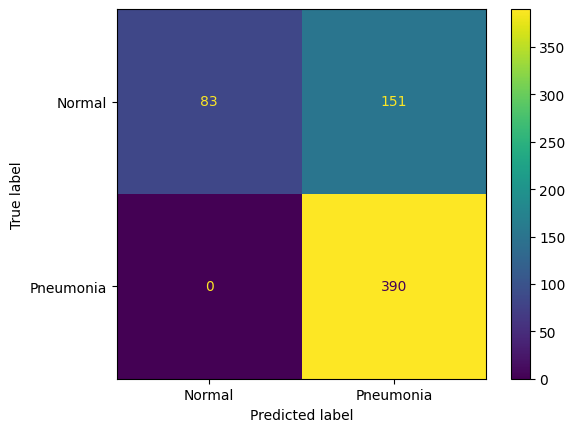

In [ ]:
print(f"VGG16 Accuracy: {vgg16_accuracy*100:.2f}%")
print(f"VGG16 F1 Score: {vgg16_f1*100:.2f}%")
print(f"VGG16 Precision: {vgg16_precision*100:.2f}%")
print(f"VGG16 Recall: {vgg16_recall*100:.2f}%")
classes = ['Normal', 'Pneumonia']
disp = ConfusionMatrixDisplay(confusion_matrix=vgg16_confusion, display_labels=classes)
disp.plot(
    include_values=True,
    cmap='viridis',
    ax=None,
    xticks_rotation='horizontal',
    values_format='d'
)

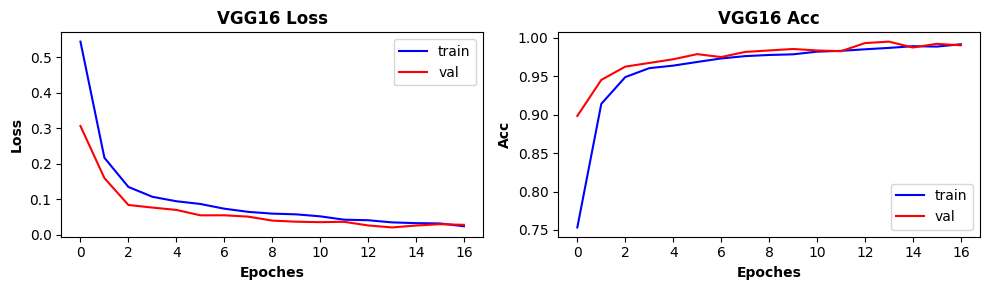

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
data = [
    (train_loss_history_vgg16, val_loss_history_vgg16, 'VGG16 Loss'),
    (train_acc_history_vgg16, val_acc_history_vgg16, 'VGG16 Acc')
]

for i, (tr, val, title) in enumerate(data):
    ax[i].plot(np.arange(early_count), tr, label='train', color='blue')
    ax[i].plot(np.arange(early_count), val, label='val', color='red')
    ax[i].set_xlabel('Epoches', fontweight='bold')
    ax[i].set_ylabel('Loss' if title == 'VGG16 Loss' else 'Acc', fontweight='bold')
    ax[i].set_title(title, fontweight='bold')
    ax[i].legend()

plt.tight_layout()
plt.show()